#  Импорт данных


In [ ]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными

import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации

import seaborn as sns # библиотека seaborn для визуализации

from sklearn.datasets import fetch_openml # функция библиотеки scikit-learn для загрузки данных с сайта OpenML

если **не** хотите рисунки на темном фоне **не** выполняйте следующую ячейку

In [ ]:
plt.style.use('dark_background')

[полный перечень стилей Matplotlib](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)

# Метод главных компонент


Метод главных компонент - это метод снижения размерности данных путем преобразования их в такую форму, чтобы оставить только максимально полезную информацию. Метод работает без учителя, поэтому под термином полезная информация в данном методе понимается набор независимых друг от друга признаков с максимальной дисперсией (с максимальным разбросом значений). При этом мы изначально полагаем, что интенсивность (в некотором смысле) полезной информации преобладает над интенсивностью каких-то случайных искажений или других не идеальностей нашего набора данных. Для выделения полезной информации в методе главных компонент проводится преобразование данных от набора исходных столбцов (исходных признаков), которые могут содержать шумы и быть линейно зависимыми к набору новых столбцов, которые обладают важным свойством линейной независимости (не коррелируют). Такие новые столбцы можно изобразить как некоторую систему координат, в которых можно отложить точки - наши данные. При этом часто оказывает так, что некоторые из координат не нужны - в них почти наверняка нет информации. Это можно представить, как если мы возьмём двухмерную фигуры и будем строить ее в трехмерной плоскости. При этом окажется, что можно выбрать такую систему координат, что третья ось не нужна. При этом даже если мы возьмём трехмерную цельную фигуры, но по одной из осей у нас будет "совсем чуть-чуть", то можно рассмотреть этот случай как двухмерный. В нашем примере две оси, в которых будет основная часть фигуры будут главными компонентами. Совокупность наших главных компонент образует т.н. собственное подпространство. Третья ось останется т.н. шумовым подпространством. Как видно из примера размерность фигуры в каждой из обозначенных осей будет соответствовать важности этой оси. Другими словами, можно сказать что разброс значений в каждой оси будет соответствовать ее важности. Такой разброс значений по каждой оси будет называться - собственные значения. Сортируя собственные значения по убыванию, мы можем определить те из них, которые следует оставить и те, которые следует убрать. Цель Метода Главных компонент найти и отбросить шумовое подпространство.

Классический метод главных компонент состоит из следующих операций:
1.	вычисление ковариационной матрицы для набора данных - то есть матрицу дисперсий.
2.	вычисление (поиск) собственных векторов и их собственных значений по ковариационной матрице.
3.	сортировка собственных значений по убыванию.
4.	выделения собственного подпространства.
5.	преобразование данных - построение проекции исходного массива на полученные собственные вектора.

1-4 операции будут реализованы функцией `fit` последняя операция будет реализована функцией `transform`. Также нами будет реализована операция `inverse_transform`, необходимая для восстоновления исходного набора данных. Важно отметить, что на практике такое восстановление может быть не точным так как сокращая разность данных вы можете удалить оттуда и часть полезной информации. Оценку точности восстоновления можно провести по метрике $R_2$, которая обсуждалась выше.

Отметим, что известно, что собственные вектора и собственные значения для некоторой квадратной матрицы $A$ удовлетворяют следующему уравнению:
$$A\vec{V}_i = \lambda_i\vec{V}_i,$$
где $\vec{V}_i$ - это собственный вектор; $\lambda_i$ - соответствующее собственное значение. По сути выражение выше представляет собой решение системы линейных уравнений с параметром $\lambda_i$. Значения данного параметра можно найти из следующего выражения:
$$ det(A-\lambda_I) = 0, $$
где $det$ - операция поиска определителя матрицы, а $\lambda_I$ - диагональная матрица с собственными значениями по главной диагонали и нулями в остальных позициях. При раскрытие операции детерменент по определению данное уравнение может быть сведено к поиску корней полнинома.





В этот раз без промежуточных шагов

Сразу создаем класс

In [ ]:
class PCA():
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.values = None
        self.mean = None

    #--------------------------------
    def fit(self, X):
        # обучение - в этом случае сводится к нахождению собственных значений и собственных векторов

        self.mean = np.mean(X, axis=0) # оценка среднего для каждого признака

        # Считаем матрицу ковариации, используя функцию библиотеки Numpy
        cov_matrix = np.cov(X - self.mean, rowvar = False) # не забываем вычитать среднее


        # считаем собственные значания и собственные вектора матрицы ковариации
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix) # для этого тоже есть функция Numpy


        idx = eigenvalues.argsort()[::-1] #Сортируем по возрастанию собственных значений

        # Берём первые n собственных векторов
        self.components = eigenvectors[:, idx][:, :self.n_components]
        self.values     = eigenvalues[idx] # отсортированные собственные значения

        return self

    #--------------------------------
    def transform(self, X):
        # преобразование признаков в пространство главных компонент
        X = X - self.mean #вычитаем среднее
        return np.dot(X, self.components) #находим проекции признаков на собственные вектора (через скалярное произведение)
        #это и будут главные компоненты
    #--------------------------------
    def fit_transform(self, X):
        # 2 в 1: обучаем и преобразуем
        return self.fit(X).transform(X)
    #--------------------------------
    def inverse_transform(self, X_new):
        # обратное преобразование
        # Главные компоненты скалярно домножаем на собственные вектора
        return np.dot(X_new, self.components.T) + self.mean # не забываем обратно добавить среднее
    #--------------------------------
    def score(self, X):
        # оцека "качества" восстановления, через коэффициент детерминации
        SStot = np.sum(np.square(X - np.mean(X)))
        SSres = np.sum(np.square(X - self.inverse_transform(self.fit_transform(X))))
        return 1 - SSres/SStot
    #--------------------------------
    def plot_eigvalues(self, figsize=(15,7)):
        # метод для отрисовки собственных значений (объясненной дисперсии)
        plt.figure(figsize=figsize)
        # отдельно мелкими точками визуализируем все собственные значения
        plt.plot(self.values,'.',
                 label='Все собственные значения',
                 linewidth = 3)
        # крупными маркерами - выбранное нами количество гласвных компонент
        plt.plot(self.values[:self.n_components],'r-o',
                 label='Собственное пространство',
                 markersize = 10, mfc='none',
                 linewidth = 2, alpha = 0.8)
        plt.ylabel('Собственные\n значения', fontsize=25)
        plt.grid();
        plt.legend(fontsize=25);
        plt.xticks(fontsize = 25); plt.yticks(fontsize = 25);
        plt.tight_layout();



In [ ]:
def plot_scatter(x,y,title_x = '', title_y = ''):
    fig = plt.figure(figsize=(10,7))
    plt.grid()

    plt.scatter(x,y,
                alpha = 0.5, s = 196,
                c = 'orange', edgecolor = 'r')
    plt.xlabel(title_x,fontsize=35)
    plt.ylabel(title_y,fontsize=35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.tight_layout();

# Синтетические данные

Как обычно в начале рассмотрим простые данные

В этот раз в виде эллипсов

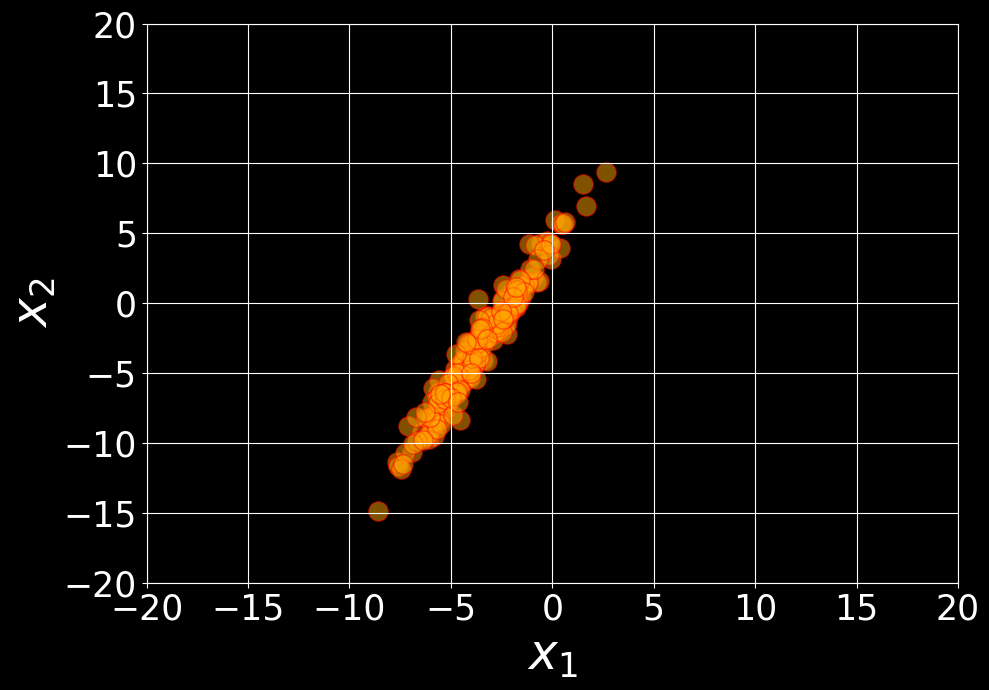

In [ ]:
#@title **Параметры распределения данных** { run: "auto" }
#@markdown ### Координаты Центра
C1 =  -3.4 #@param {type:"slider", min:-5, max:5, step:0.1}
C2 =  -2.8 #@param {type:"slider", min:-5, max:5, step:0.1}
#@markdown ### Радиусы
S1 =  5 #@param {type:"slider", min:0, max:5, step:0.1}
S2 =  0.4 #@param {type:"slider", min:0, max:5, step:0.1}
#@markdown ### Угол наклона
theta = 65 #@param {type:"slider", min:0, max:90, step:5}
#@markdown ### Количество точек
N = 200 #@param {type:"slider", min:100, max:2000, step:100}

# фиксированный сид случайных чисел (для повторяемости)
np.random.seed(42)

theta = np.pi*theta/180 # переводим угл в радианы

# группируем в один вектор
Centers = np.array([C1,C2]) # центры
Sigmas = np.array([S1,S2]) # и радиусы эллипса

# Матрица поворота
R = np.array([[np.cos(theta), - np.sin(theta)],
              [np.sin(theta), np.cos(theta)]])

# Генерируем данные (ниже будет пошагово рассмотрено что происходит)
X = R @ np.diag(Sigmas) @ np.random.randn(2, N)+np.diag(Centers)@ np.ones((2, N))

# транспонируем чтобы данные были в формате (количество точек, количество признаков)
X = X.T
# Визуализируем результат

plot_scatter(X[:,0],X[:,1],r'$x_1$', r'$x_2$')


Исходные данные - N случайных данных из нормального распределения (нулевое среднее, единичная дисперсия)

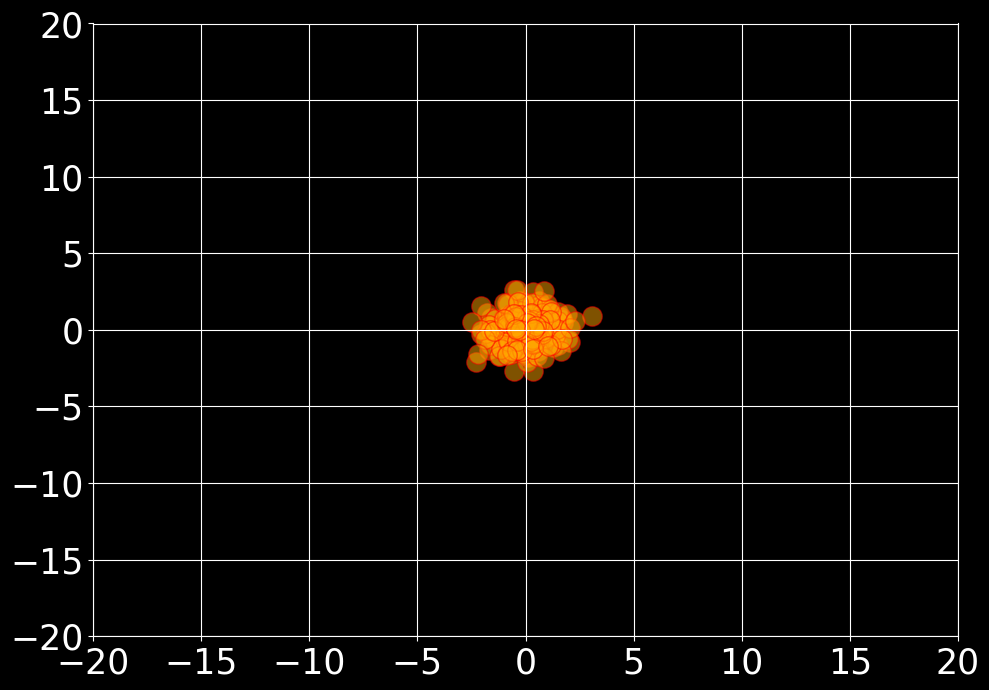

In [ ]:
rand = np.random.randn(2, N)
plot_scatter(rand[0,:],rand[1,:])

Растягиваем нормальное распределение

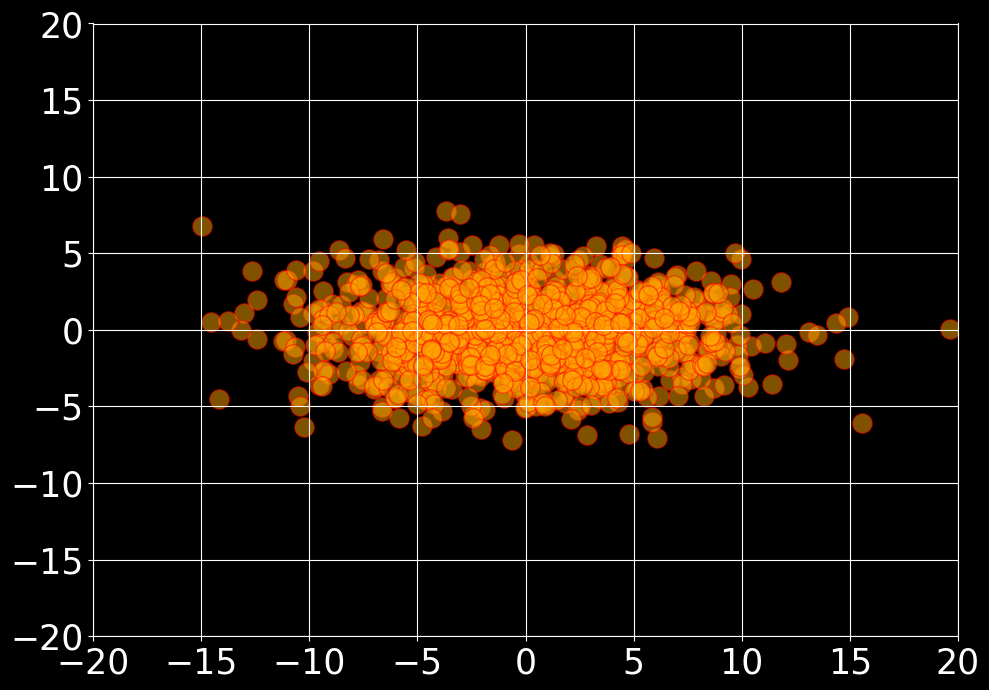

In [ ]:
scretch = np.diag(Sigmas) @ rand
plot_scatter(scretch[0,:],scretch[1,:])

Поворачиваем

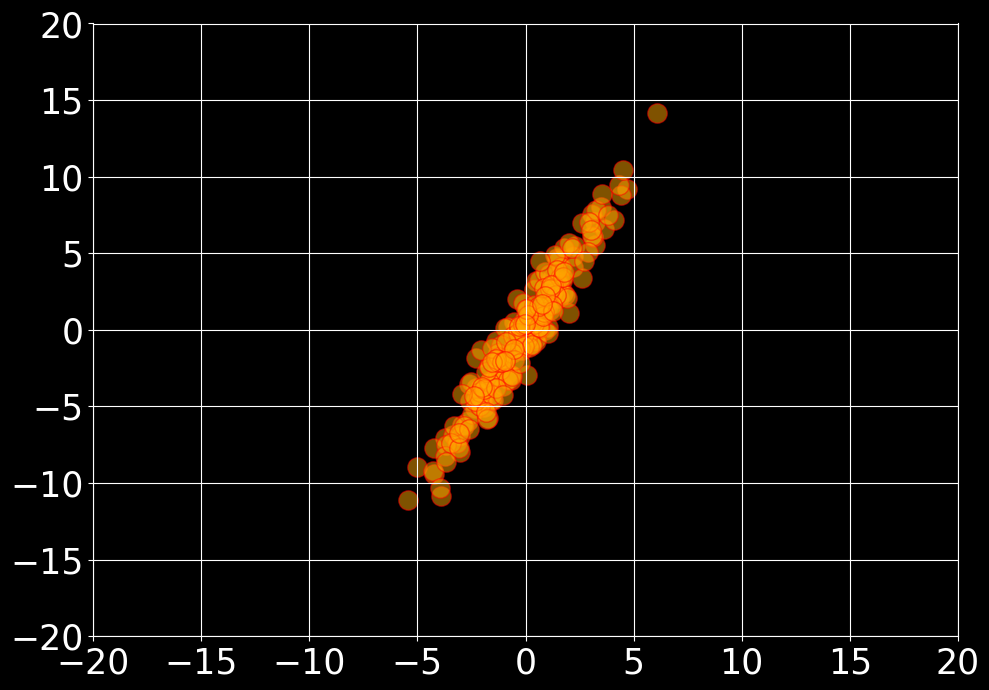

In [ ]:
rotate = R @ scretch
plot_scatter(rotate[0,:],rotate[1,:])

Сдвигаем центр

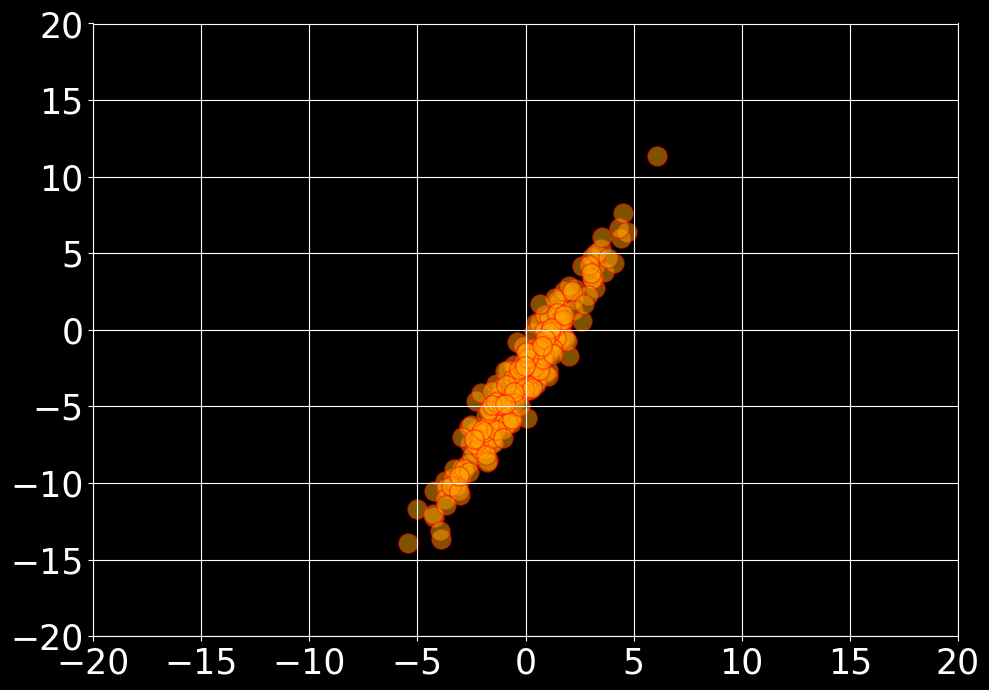

In [ ]:
shift = rotate + np.diag(Centers)@ np.ones((2, N))
plot_scatter(shift[0,:],shift[1,:])

Упакуем всё в функцию

In [ ]:
def create_elipsoid_data(C1 = 0, C2 = 0, S1 = 5, S2 =1, theta =45, N = 250, random_state = 42):
    """Генерация набора данных в виде эллипса
    Входные переменные:
    ===========
    С1 и С2: координаты центра
    S1 и S2: радиусы эллипса
    theta: угол наклона
    N: количество точек данных
    random_state: фиксированный сид случайных чисел (для повторяемости)
    """
    # фиксированный сид случайных чисел (для повторяемости)
    np.random.seed(random_state)

    # переводим угл в радианы
    theta = np.pi*theta/180

    # группируем в один вектор
    Centers = np.array([C1,C2]) # центры
    Sigmas = np.array([S1,S2]) # и радиусы эллипса

    # Матрица поворота
    R = np.array([[np.cos(theta), - np.sin(theta)],
                [np.sin(theta), np.cos(theta)]])
    # транспонируем чтобы данные были в формате (количество точек, количество признаков)
    return (R @ np.diag(Sigmas) @ np.random.randn(2, N)+np.diag(Centers)@ np.ones((2, N))).T


Проверим функцию в деле

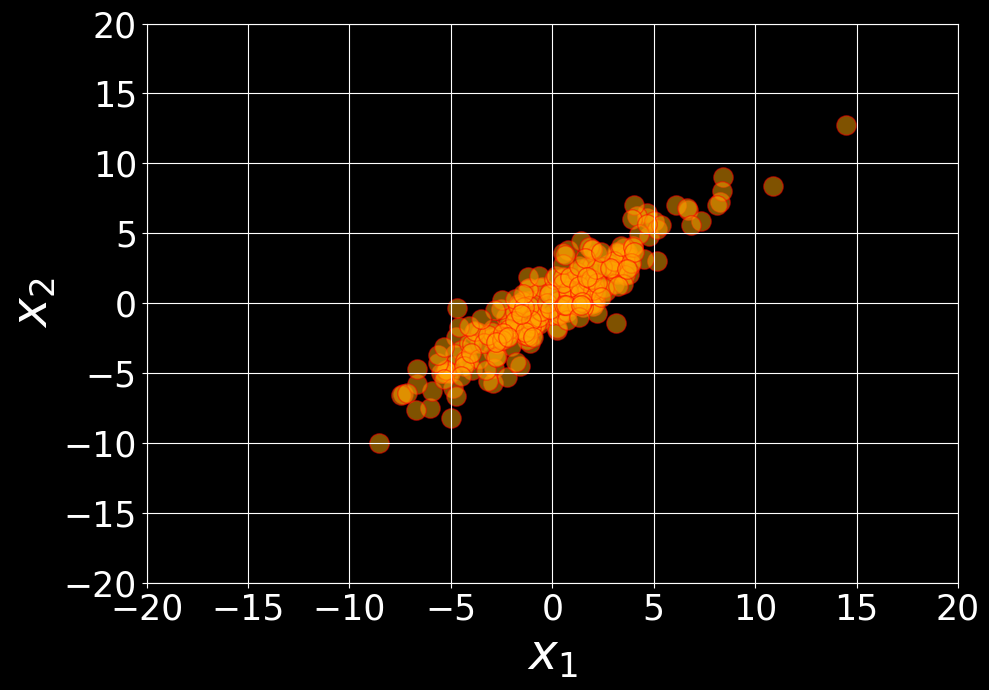

In [ ]:
X =create_elipsoid_data(C1 = 0, C2 = 0, S1 = 5, S2 =1, theta =45, N = 250, random_state = 42)

plot_scatter(X[:,0],X[:,1],r'$x_1$', r'$x_2$')

## Применяем разработанный Класс PCA

Выбора у нас немного, поэтому задаем максимально количество компонент

И стандартная для нас последовательность

* Создаем модель-объект

* Обучаем через `.fit()`

* Оцениваем через `.score()`

In [ ]:
pca = PCA(n_components = 2)
pca.fit(X)
pca.score(X)

1.0

Считаем пространство главных компонент

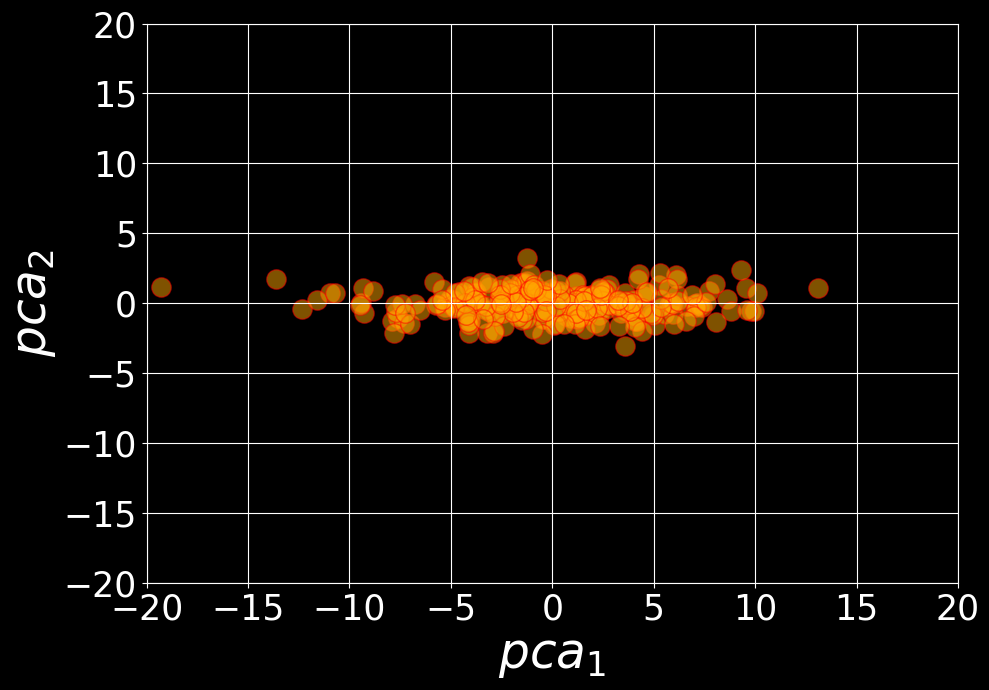

In [ ]:
X_new = pca.transform(X) # воспользуемся методом transform

# И делаем стандартную визуализацию
plot_scatter(X_new[:,0],X_new[:,1],r'$pca_1$', r'$pca_2$')


Если надо будет "взлянуть" на собственные значения и собственные вектора, то они в соответсвующих аттрибутах

In [ ]:
Eigen_Vectors = pca.components
Eigen_Values = pca.values

Проверим, что полученные собственные вектора и собственные  значения действительно связаны с распределением исходных данных

Для этого выполним аффинное преобразование единичной окружности, используя собственные вектора для определения угла наклона эллипса, а собственные значения как характерный размер вдоль соответсвующей оси эллипса

In [ ]:
X_mean = np.mean(X, axis = 0)

theta_ = 2 * np.pi * np.arange(0,1,0.01)

X_std = Eigen_Vectors @ np.diag(np.sqrt(Eigen_Values)) @ np.array([np.cos(theta_),np.sin(theta_)])



"Теория" говорит о том, что полученный эллипс должен содержать в себе распределение 68% от всех точек (1 стандартное отклонение от среднего)

При этом если оси эллипса увеличить в два раза то в таком эллипсе будет 95% точек (2 стандартных оклонений от среднего)

Выполним визуализацию исходных данных, эллипсов полученыых из собственных значений и векторов, с поправкой на среднее значение, а также базис из главных компонент

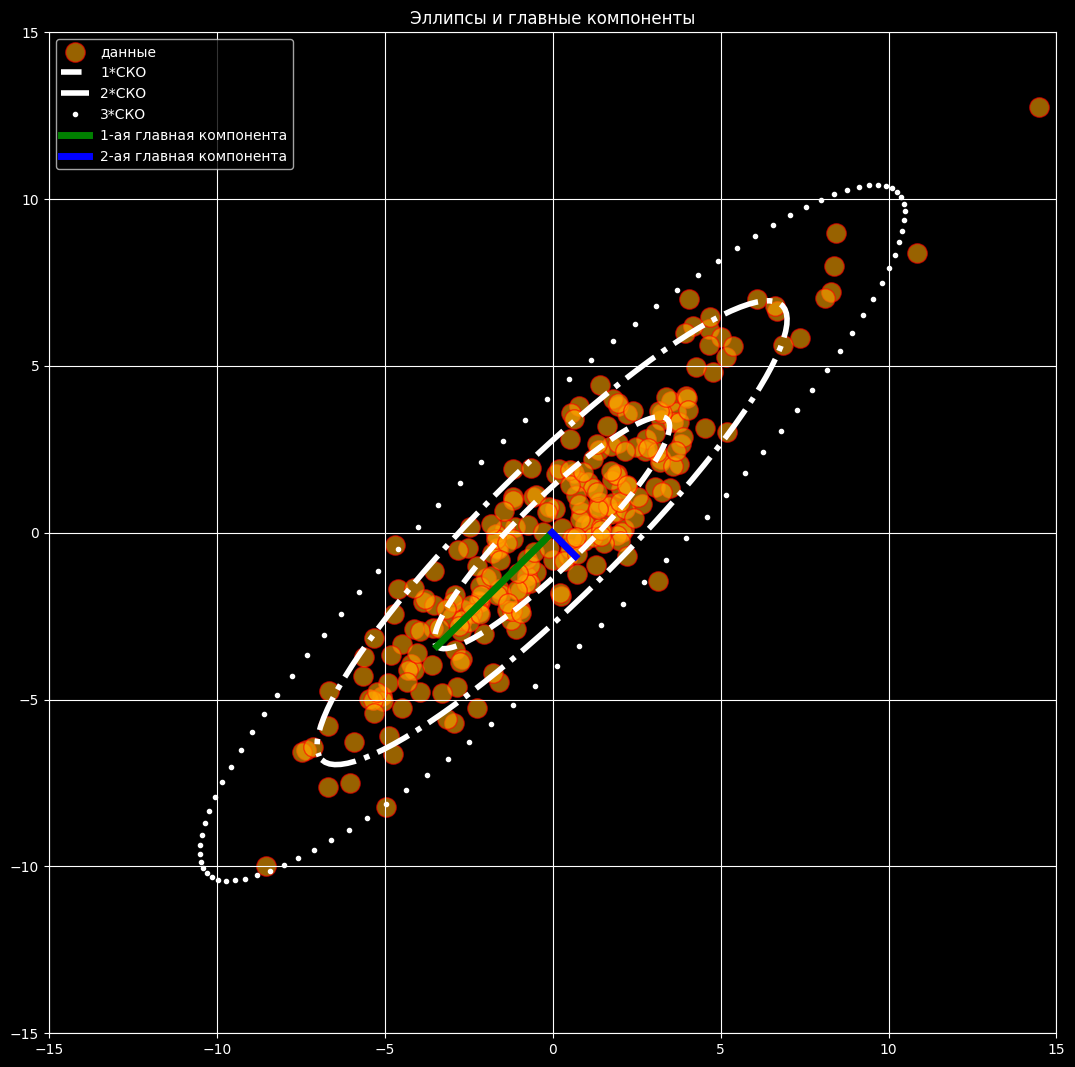

In [ ]:
fig = plt.figure(figsize=(13,13))
# рисуем данные
plt.scatter(X[:,0],X[:,1], alpha = 0.6, label = 'данные',s = 196, c = 'orange', edgecolor = 'r')
# рисуем эллипс с "диаметром" ~ 1*СКО
plt.plot(X_std[0,:]+X_mean[0],X_std[1,:]+X_mean[1],
         '--', c = 'w', linewidth = 4, label = '1*СКО')
#рисуем эллипс с "диаметром" ~ 2*СКО
plt.plot(2*X_std[0,:]+X_mean[0],2*X_std[1,:]+X_mean[1],
         '-.', c = 'w', linewidth = 4, label = '2*СКО')
#рисуем эллипс с "диаметром" ~ 3*СКО
plt.plot(3*X_std[0,:]+X_mean[0],3*X_std[1,:]+X_mean[1],
         '.', c = 'w', linewidth = 4, label = '3*СКО')
# 1-ая главная компонента
plt.plot(np.array([X_mean[0], X_mean[0]+Eigen_Vectors[0,0]*np.sqrt(Eigen_Values[0])]),
         np.array([X_mean[1], X_mean[1]+Eigen_Vectors[1,0]*np.sqrt(Eigen_Values[0])]),
         'g',linewidth = 5, label = '1-ая главная компонента')
# 2-ая главная компонента
plt.plot(np.array([X_mean[0], X_mean[0]+Eigen_Vectors[0,1]*np.sqrt(Eigen_Values[1])]),
         np.array([X_mean[1], X_mean[1]+Eigen_Vectors[1,1]*np.sqrt(Eigen_Values[1])]),
         'b',linewidth = 5, label = '2-ая главная компонента')
plt.xlim((-15,15))
plt.ylim((-15,15))
plt.title('Эллипсы и главные компоненты')
plt.legend()
plt.grid()


Вроде все совпадает с теорием

# Посмотрим на почти Реальных данных

В качестве данных мы рассмотрим набор данных MNIST

Классический набор изображений рукописных цифр

Размер изображений 28 на 28, что можно рассматривать как большую таблицу признаков из 784 столбцов

Единственный канал - "оттенки серого"

Изображения хранятся в 8-битном формате, т.е. оттенков серого 256 от 0 (черный) до 255 (белый)

In [ ]:
# воспользуемся функцией fetch_openml для загрузки данных с сайта OpenML
# для этого нам необходимо знать имя набора данных и версию
# также указываем что хотим чтобы скачалось в формате признаки/целевые метки (return_X_y)
# иначе он выгрузит в формате словаря с полной выкладкой
# наконец попросим выгрузить данные в формате dataframe (as_frame)
# иначе будут numpy массивы
X, y  = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame = True)
X = X / 255. # нормализуем данные - из диапазона от 0 до 255 в диапазон от 0 до 1
X_ = X.values # отдельно сохраним данные в формате numpy

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Посмотрим на нашу табличку данных

In [ ]:
X

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


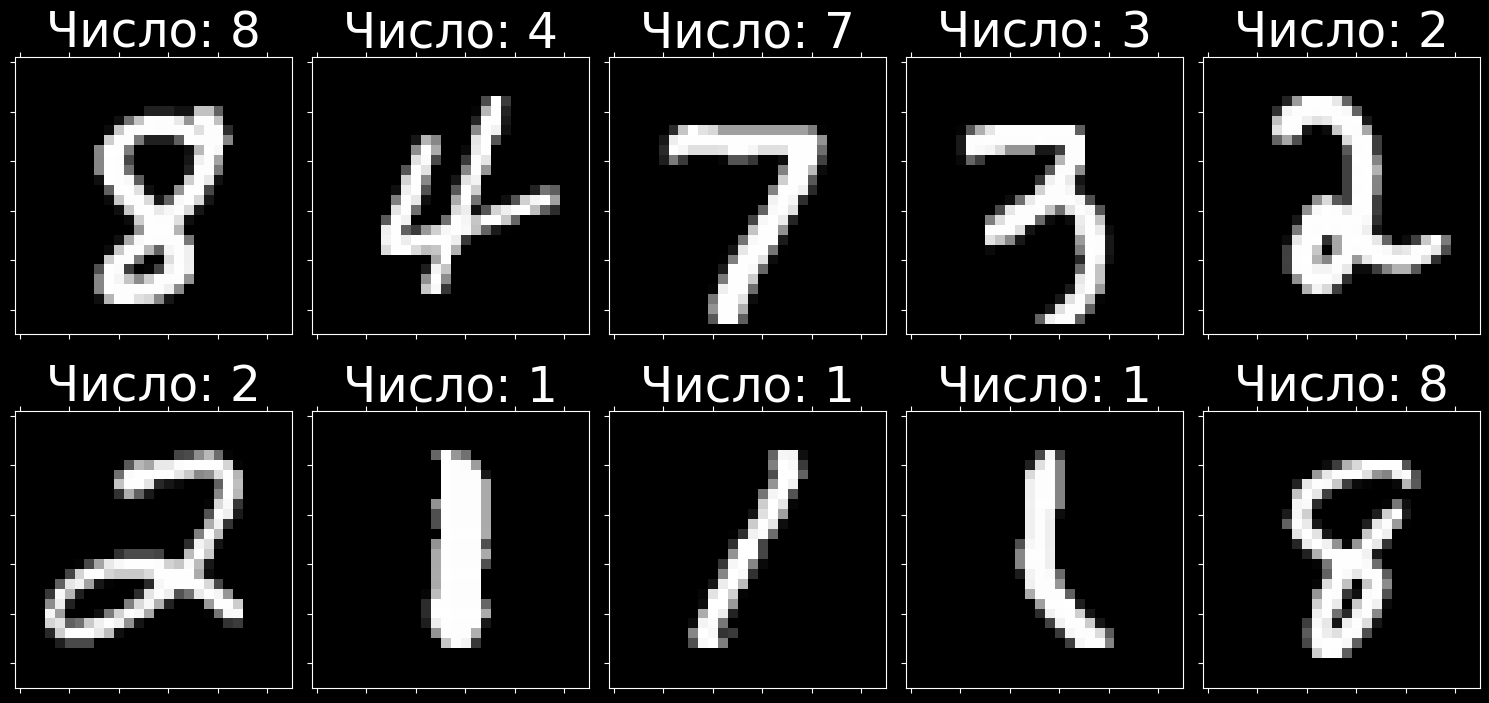

In [ ]:
#@title Разные примеры { run: "auto" }
n =  15258 #@param {type:"slider", min:1, max:69984, step:1}

# создаем полотно
fig = plt.figure( figsize=(15,8) )
# на котором визуализируем 10 примеров изображений
# начиная с индекса n
for i in range(0,10):
    # каждое изображение будет на своем сабплоте
    ax = fig.add_subplot(2,5,i+1)
    # пишем какое число должно быть
    ax.set_title("Число: {}".format(str(y[i+n]) ), size=35)
    # отрисовываем с помощью функции matshow
    # для этого нам вектор-строку из 784 элементов
    # нужно преобразовать в матрицу 28 на 28
    ax.matshow(1-X.loc[i+n,'pixel1':'pixel784'].values.reshape((28,28)).astype(float),
                cmap='Greys')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.tight_layout()


С помощью слайдера можно выбрать другие изображения для визуализации

Посмотрим на наши данные

Но не как на цифры, а как на табличные данные

Возьмем и отрисуем "немного", а то это будет долго рисовать

In [ ]:
X_plot = X.loc[0:1000,'pixel371':'pixel375'].copy()

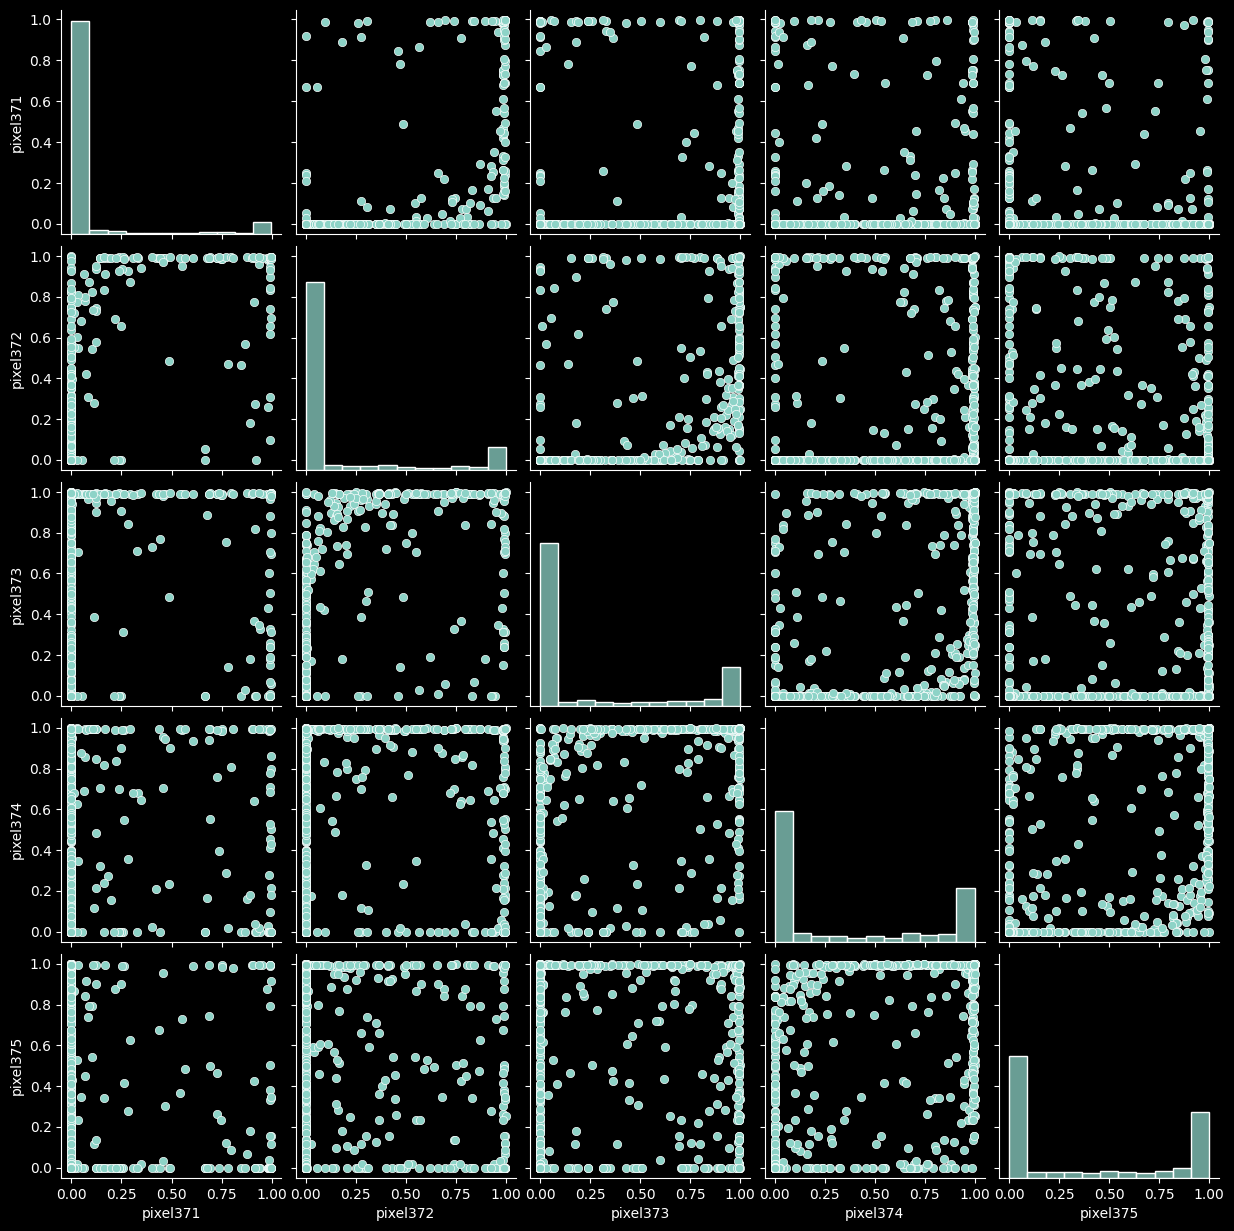

In [ ]:
sns.pairplot(X_plot);

In [ ]:
X_plot = X.loc[0:1000,'pixel1':'pixel5'].copy()

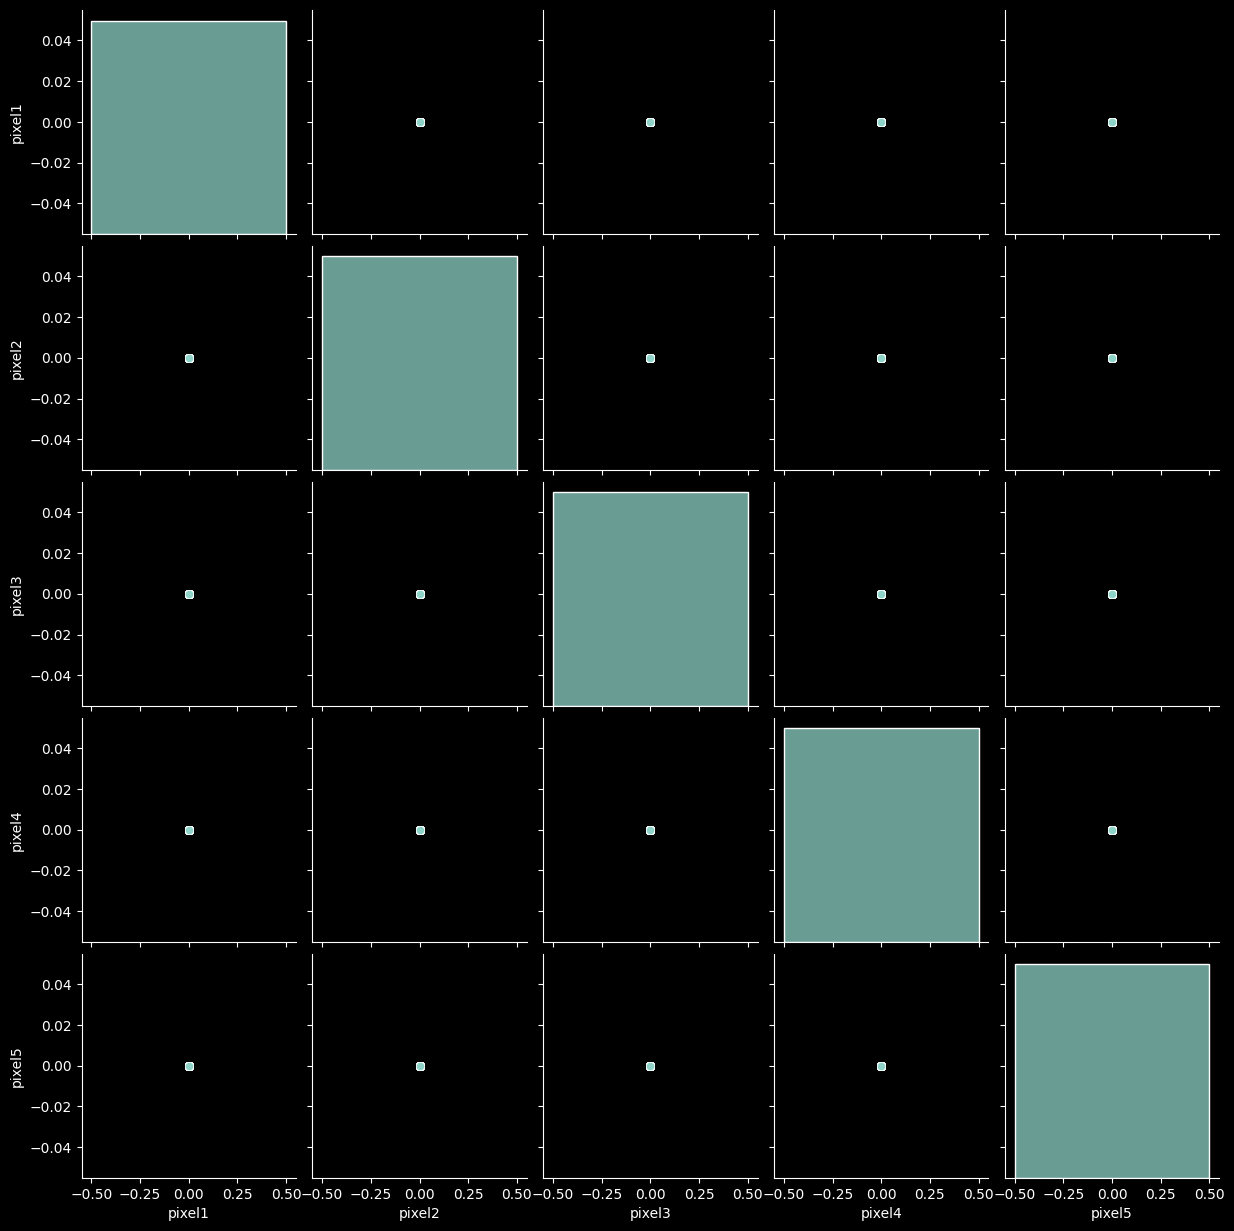

In [ ]:
sns.pairplot(X_plot);

И вот на это все мы будем смотреть как на эллипсы)

Но прицип остается тот-же

Метод главный компонени будет смотреть на признаки `pixel1-5` как относительно "бесполезный", т.к.он "почти всегда 0"

Что менее интересно, с т.з. дисперсии, чем скажем признаки `pixel370-735`

## Применяем Метод Главных Компонент к Данным MNIST

И вновь стандартная для нас последовательность

* Создаем модель-объект (в этот раз ограничемся, допустим 100 компонентами)

* Обучаем через `.fit()`

* Оцениваем через `.score()`


In [ ]:
pca = PCA(n_components = 100)
pca.fit(X_)
pca.score(X_)

0.9398662110143557

Оцениваем пространство главных компонент

In [ ]:
pca_result_mnist = pca.transform(X_)

Восстанавливаем исходные изображения из 100 главных компонент

In [ ]:
pca_inverse = pca.inverse_transform(pca_result_mnist)

Убеждаемся что размерность восстановленного изображения верная

In [ ]:
pca_inverse.shape

(70000, 784)

## Визуализация

Разная

**Собственные значения**

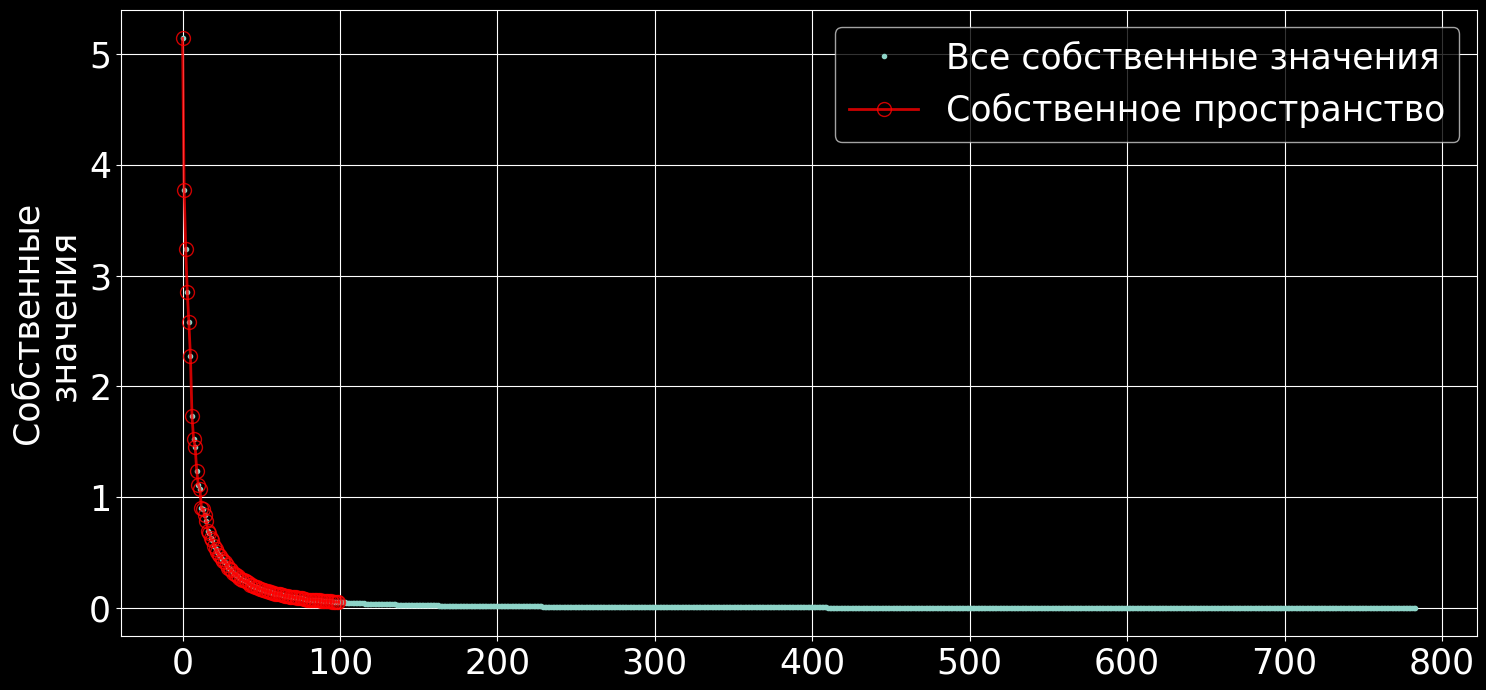

In [ ]:
pca.plot_eigvalues();

**Очень интересный график**

In [ ]:
def plot_multi(data, y,  names):
    """Нескольких двумерных проекций многомерных данных (pairplot на минималках)
    Входные переменные:
    ===========
    data: данные
    y: целевые метки
    names: подписи к осям
    """
    # собираем оси данных, которые мы визуализируем
    axis = [[0,1],
            [2,1],
            [0,3],
            [2,3],]

    # собираем подписи к осям в нужном порядке
    labels = [['',names[1]],
            ['',''],
            [names[0],names[3]],
            [names[2],'']]

    # создаем полотно 2 на 2
    fig, sub = plt.subplots(2, 2, figsize = (11,11))

    # в каждом графике этого полотна мы визуализируем соответсвующие проекции
    for n, (axi, label, ax) in enumerate(zip(axis,  labels, sub.flatten())):
        # визуализация - стандартная скатерограмма
        scatter = ax.scatter(data[:,axi[0]],data[:,axi[1]],
                             c=y,  # разные метки будут подсвечены разным цветом
                             s = 36, cmap = 'tab10',
                             alpha = 0.7, facecolors = 'none' );
        ax.set_ylabel(label[1], fontsize = 20)
        ax.set_xlabel(label[0], fontsize = 20)
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)
        ax.grid()
        ax.set_xlim([-10,12])
        ax.set_ylim([-8,8])
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Цифры",
                        fontsize = 15) # собираем легенду
        ax.add_artist(legend1)

Генерируем подписи к осям

In [ ]:
pca_names = [str(x+1)+'-я главная компонента' for x in range(4)]

**Пространство Главных Компонент**

Точнее некоторые вариации 4 проекций первых главных компонент

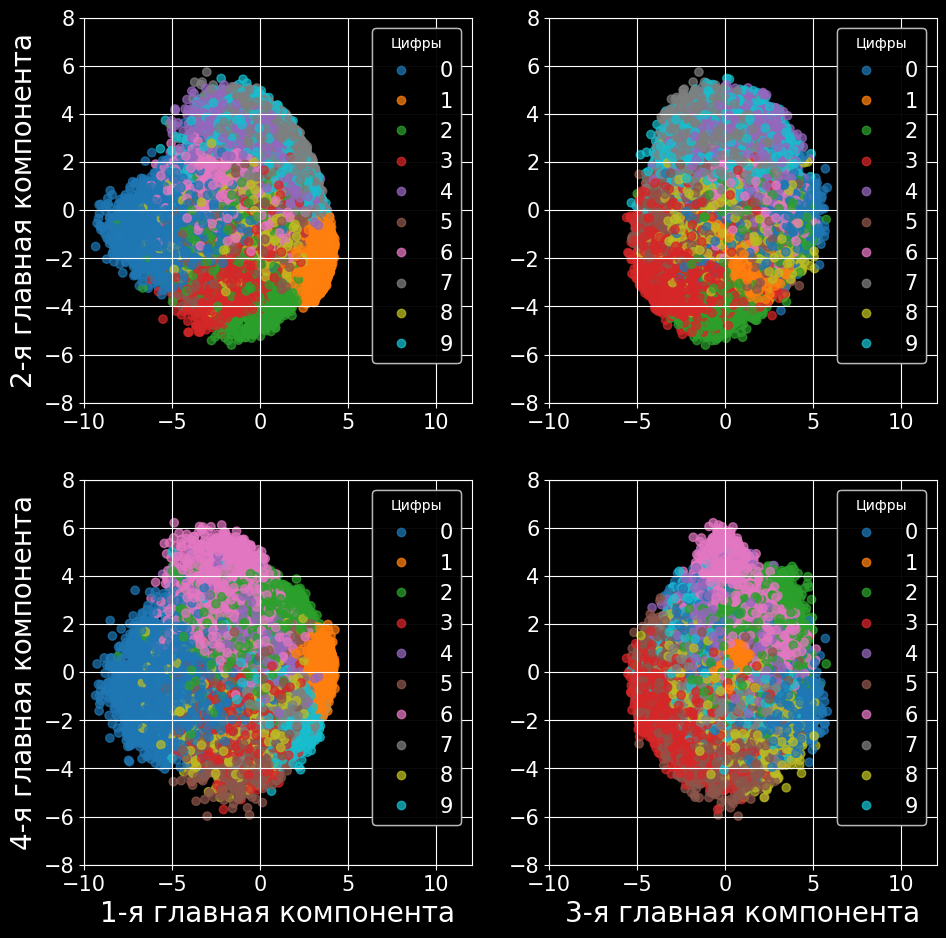

In [ ]:
plot_multi(pca_result_mnist, y.astype(int), pca_names);

## Восстановление данных

Сравним восстановленные изображения с исходными

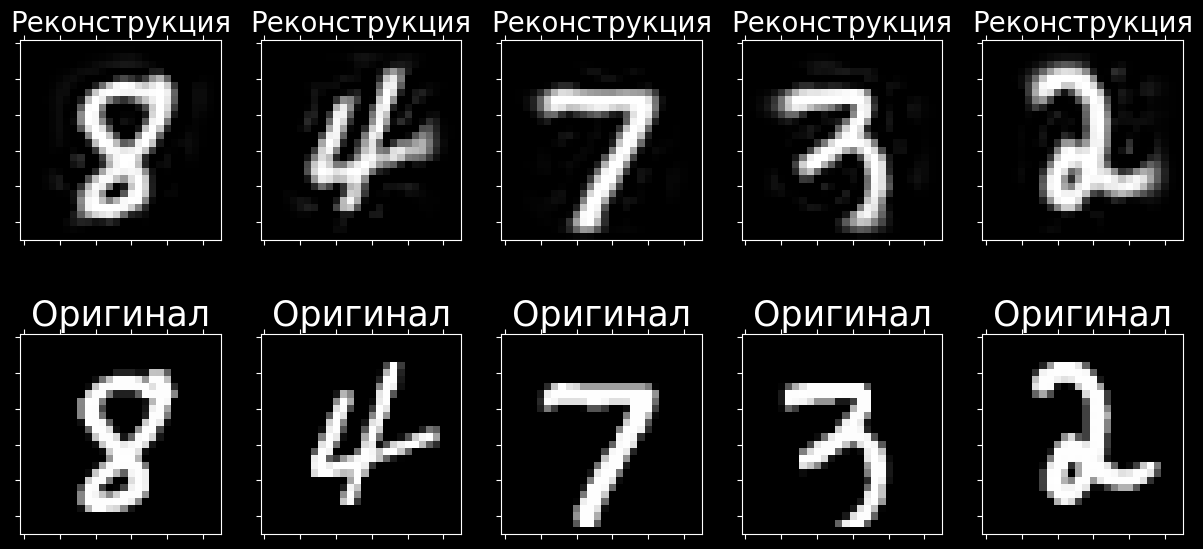

In [ ]:
#@title Разные примеры { run: "auto" }
n =  15258 #@param {type:"slider", min:1, max:69984, step:1}


fig=plt.figure(figsize=(15,7))
for i in range(0,5):
  ax = fig.add_subplot(2,5,i+1)
  ax.set_title("Реконструкция", size=20)
  ax.matshow(1-pca_inverse[i+n,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

for i in range(0,5):
  ax = fig.add_subplot(2,5,i+6)
  ax.set_title("Оригинал", size=25)
  ax.matshow(1-X_[i+n,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

## Попытка понять что значат главные компоненты

Визуализируем собственные вектора сделал преобразование от вектор-строки из 784 элементов в матрицу 28 на 28

Поскольку, напоминаю, что отдельный собственный вектор это веса всех исходных  признаков в отдельных главных компонентах. Т.е. это вектор соразмерный с исходными данными, а значит его тоже можно представить в виде изображения

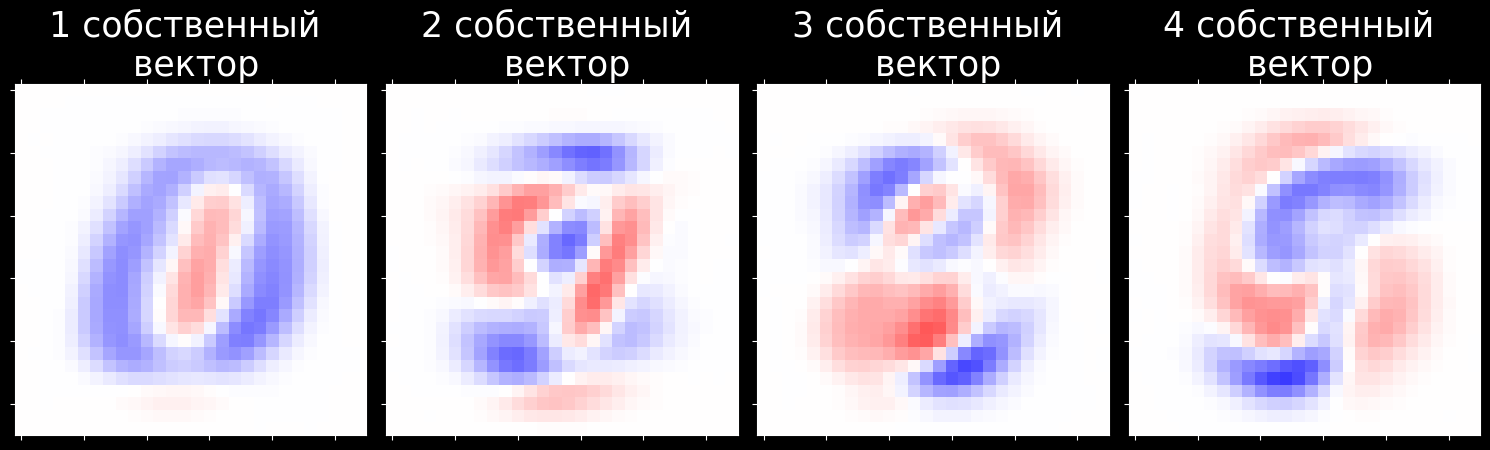

In [ ]:
W_pca=pca.components.T
fig=plt.figure(figsize=(15,5))
for i in range(0,4):
  ax = fig.add_subplot(1,4,i+1,title=str(i+1) )
  ax.set_title("{} собственный \n вектор".format(str(i+1)), size=25)
  ax.matshow(W_pca[i].reshape((28,28)).astype(float), cmap = 'bwr', vmin=-0.20,vmax = 0.20)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout();

In [ ]:
pca.components.shape

(784, 100)

Посмотрим на относительно значимые признаки для первой главной компоненты

Их почти 456 - т.е. для первой главной компоненты важно знать информацию о 456 пикселей исходных изображений

При этом используя только их можно вполне уверенно отличать 0 от 1

И это без всяких целевых переменных

In [ ]:
sum(np.abs(pca.components[:,0])>0.001)

456

Плюс большое количество ненулевых признаков в первой главной компоненте показывает что исходные данные не так просты, и чтобы "развернуть эллипс как надо" необходимо задействовать большое количество признаков

А поэтому не надо удивляться что в исходных данных такого не видно - угол не тот

Посмотрим на веса исходных признаков в 100 первых главных

В частности посмотрим на "бесполезные" пиксели (с 1 по 4)

и

Отсносительно полезные (с 371 по 374)

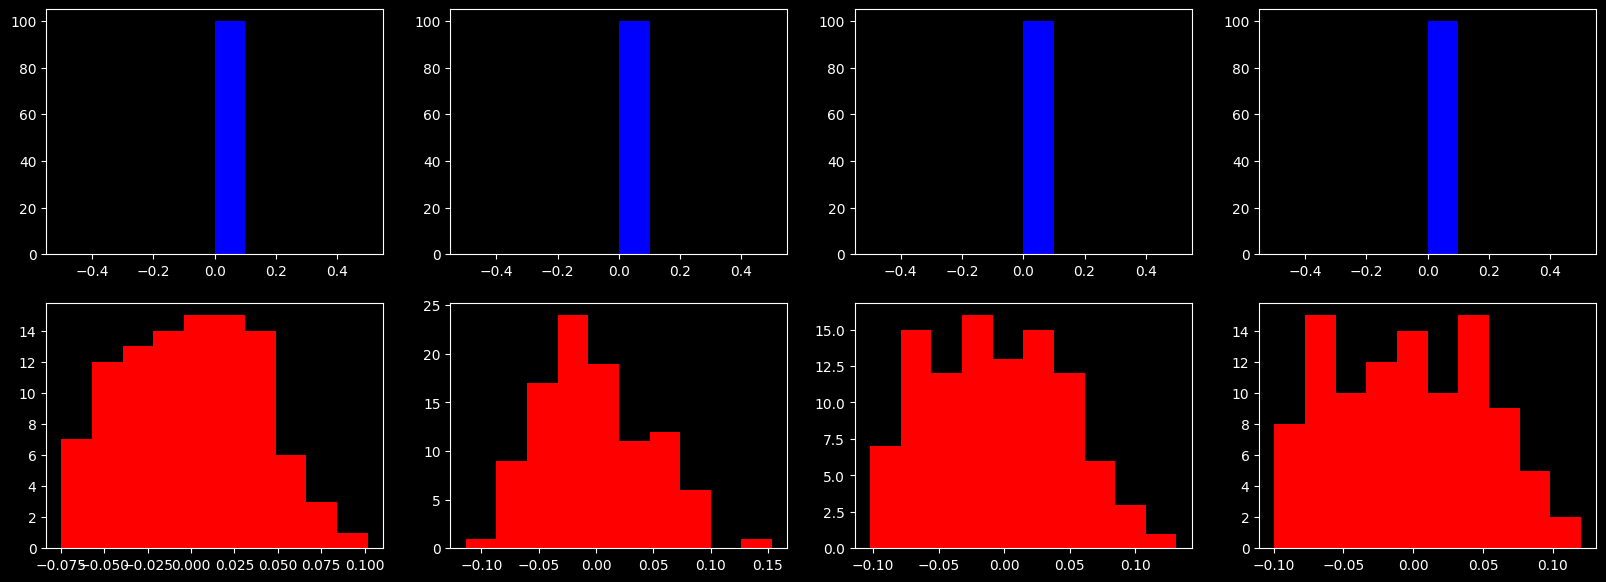

In [ ]:
fig = plt.figure(figsize = (20,7))

plt.subplot(241)
plt.hist(pca.components[0,:],color='b')

plt.subplot(242)
plt.hist(pca.components[1,:],color='b')

plt.subplot(243)
plt.hist(pca.components[2,:],color='b')

plt.subplot(244)
plt.hist(pca.components[3,:],color='b')

plt.subplot(245)
plt.hist(pca.components[370,:],color='r')

plt.subplot(246)
plt.hist(pca.components[371,:],color='r')

plt.subplot(247)
plt.hist(pca.components[372,:],color='r')

plt.subplot(248)
plt.hist(pca.components[373,:],color='r');

Бесполезные признаки имеют вес строго 0

Для относительно бесполезных признаков есть разрос весов - есть как положительные, так и отрицательные

А значит что-то оказывается полезным с т.з. главных компонент

Таким образом метод главных компонент сам понял какие пиксели важные, а какие нет

